In [0]:
SANDBOX_NAME = 'fesc' # Sandbox Name
DATA_PATH = "/data/sandboxes/"+SANDBOX_NAME+"/data/"



# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Cargar librerías

In [0]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.cross_validation import train_test_split
#from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
#from sklearn.grid_search import GridSearchCV, ParameterGrid
#from sklearn.cluster import KMeans



## Lectura de datos

In [0]:
#Importamos la librería Drive para poder montar la unidad de Google Drive y poder leer los .csv que tenemos almacenados
from google.colab import drive

In [0]:
#Montamos la unidad de Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
#Leemos cada uno de los ficheros .csv y los almacenamos en una variable para poder leer los datos
#Como el separador de los ficheros es la coma no hace falta indicar el separador
diabetes = pd.read_csv('/content/drive/My Drive/workshop/data/diabetic_data.csv')
admission_source = pd.read_csv('/content/drive/My Drive/workshop/data/admission_source_id.csv')
admission_type = pd.read_csv('/content/drive/My Drive/workshop/data/admission_type_id.csv')
discharge_disposition = pd.read_csv('/content/drive/My Drive/workshop/data/discharge_disposition_id.csv')



### Comprobar correcta lectura de los datos

In [0]:
#Con un head(),sample() y tail() vamos revisando que la lectura de los ficheros ha sido correcta
diabetes.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


In [0]:
#Guardamos el número de registros de diabetes para hacer comprobaciones cuando juntemos las tablas
num_reg_diabetes = diabetes.shape[0]
#Guardamos el número de columnas de diabetes para hacer comprobaciones cuando juntemos las tablas
num_col_diabetes = diabetes.shape[1]
print(num_reg_diabetes,num_col_diabetes)

101766 50


In [0]:
admission_source.sample(10)

,admission_source_id,description
15,17,None
14,15,Not Available
5,6,Transfer from another health care facility
8,9,Not Available
2,3,HMO Referral
10,11,Normal Delivery
4,5,Transfer from a Skilled Nursing Facility (SNF)
13,14,Extramural Birth
0,1,Physician Referral
23,25,Transfer from Ambulatory Surgery Center


In [0]:
admission_type.tail(10)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,None
6,7,Trauma Center
7,8,Not Mapped


In [0]:
discharge_disposition.head()

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution




### Juntar todos los datos en el mismo DataFrame

In [0]:
#Juntamos el DataFrame diabetes y admission_source por la columna "admission_source_id"
diab_ad_so = pd.merge(diabetes, admission_source, on=['admission_source_id'], how='inner')

In [0]:
#Comprobamos que tenemos 1 columna más en el DataFrame
if diab_ad_so.shape[1] == num_col_diabetes+1:
  print("Se ha añadido una columna")
else:
  print("Error al añadir columna")

Se ha añadido una columna


In [0]:
#Comprobamos que tenemos las mismas filas en el DataFrame
if diab_ad_so.shape[0] == num_reg_diabetes:
  print("El DataFrame tiene el mismo número de filas")
else:
  print("Error. Se han añadido nuevos registros")

El DataFrame tiene el mismo número de filas


In [0]:
##Juntamos el DataFrame diabetes y admission_source por la columna "admission_type_id"
diab_ad_so_ty = pd.merge(diab_ad_so, admission_type, on=['admission_type_id'], how='inner')

In [0]:
#Comprobamos que tenemos 1 columna más en el DataFrame
if diab_ad_so_ty.shape[1] == num_col_diabetes+2:
  print("Se ha añadido una columna")
else:
  print("Error al añadir columna")

Se ha añadido una columna


In [0]:
#Comprobamos que tenemos las mismas filas en el DataFrame
if diab_ad_so_ty.shape[0] == num_reg_diabetes:
  print("El DataFrame tiene el mismo número de filas")
else:
  print("Error. Se han añadido nuevos registros")

El DataFrame tiene el mismo número de filas


In [0]:
pacientes = pd.merge(diab_ad_so_ty, discharge_disposition, on=['discharge_disposition_id'], how='inner')

In [0]:
#Comprobamos que tenemos 1 columna más en el DataFrame
if pacientes.shape[1] == num_col_diabetes+3:
  print("Se ha añadido una columna")
else:
  print("Error al añadir columna")

Se ha añadido una columna


In [0]:
#Comprobamos que tenemos las mismas filas en el DataFrame
if pacientes.shape[0] == num_reg_diabetes:
  print("El DataFrame tiene el mismo número de filas")
else:
  print("Error. Se han añadido nuevos registros")

El DataFrame tiene el mismo número de filas


In [0]:
#Quitamos los puntos, comas y espacios y ponemos los literales de las columnas en minúsculas
pacientes.columns =[x.lower().replace(" ","_").replace(".","").replace("-","_") for x in pacientes.columns]



### Estudiar las dimensiones del dataset

In [0]:
#Comprobamos que tenemos 1 columna más en el DataFrame
if pacientes.shape[1] == num_col_diabetes+3:
  print("Se ha añadido una columna")
else:
  print("Error al añadir columna")

Se ha añadido una columna


In [0]:
#Comprobamos que tenemos las mismas filas en el DataFrame
if pacientes.shape[0] == num_reg_diabetes:
  print("El DataFrame tiene el mismo número de filas")
else:
  print("Error. Se han añadido nuevos registros")

El DataFrame tiene el mismo número de filas




## Data Wrangling



### Cambiar los nombres de las columnas para que cumplan buenas prácticas

In [0]:
#Cambiamos los nombre de las columnas añadidas
pacientes = pacientes.rename(columns={'description_x':'admission_source', 'description_y':"admission_type","description":"discharge_disposition"})
pacientes.sample(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,admission_source,admission_type,discharge_disposition
13495,290529708,101952450,Caucasian,Female,[70-80),?,2,1,7,1,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Urgent,Discharged to home
63721,71036448,20638935,Caucasian,Male,[60-70),?,2,3,4,11,...,No,No,No,No,No,Yes,NO,Transfer from a hospital,Urgent,Discharged/transferred to SNF
79947,148648656,43724214,Caucasian,Female,[70-80),?,1,6,7,9,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged/transferred to home with home health service
84424,40230036,448875,AfricanAmerican,Female,[60-70),?,3,6,1,7,...,No,No,No,No,Ch,Yes,>30,Physician Referral,Elective,Discharged/transferred to home with home health service
93780,141797046,61734870,Caucasian,Male,[60-70),?,2,22,1,7,...,No,No,No,No,Ch,Yes,<30,Physician Referral,Urgent,Discharged/transferred to another rehab fac including rehab units of a hospital .
42976,361957802,136179122,Hispanic,Female,[20-30),?,1,1,7,5,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
93681,287509512,43722216,Caucasian,Female,[50-60),?,3,23,4,10,...,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Elective,Discharged/transferred to a long term care hospital.
63137,182256498,34312311,Caucasian,Female,[70-80),?,2,3,7,12,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Urgent,Discharged/transferred to SNF
71625,349587410,112724487,Caucasian,Female,[80-90),[50-75),1,3,6,3,...,No,No,No,No,Ch,Yes,NO,Transfer from another health care facility,Emergency,Discharged/transferred to SNF
46772,107862840,2904984,AfricanAmerican,Female,[70-80),?,1,1,6,3,...,No,No,No,No,Ch,Yes,NO,Transfer from another health care facility,Emergency,Discharged to home




### Estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

In [0]:
#Comprobamos los tipos de los datos y revisamos los datos para ver si tenemos que cambiar algún tipo
pacientes.dtypes

encounter_id                int64 
patient_nbr                 int64 
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           int64 
discharge_disposition_id    int64 
admission_source_id         int64 
time_in_hospital            int64 
payer_code                  object
medical_specialty           object
num_lab_procedures          int64 
num_procedures              int64 
num_medications             int64 
number_outpatient           int64 
number_emergency            int64 
number_inpatient            int64 
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses            int64 
max_glu_serum               object
a1cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [0]:
#Vamos mirando las columnas para el ver cómo son los datos
pacientes[pacientes.columns[28:]].head(5)

,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,...,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,admission_source,admission_type,discharge_disposition
0,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Ch,Yes,>30,Physician Referral,None,Not Mapped
2,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
3,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,Ch,Yes,NO,Physician Referral,None,Not Mapped
4,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,>30,Physician Referral,None,Not Mapped


In [0]:
#Vamos recorriendo las columnas y miramos primero cuántos datos distintos tiene cada columna
pacientes.nunique()

encounter_id                101766
patient_nbr                 71518 
race                        6     
gender                      3     
age                         10    
weight                      10    
admission_type_id           8     
discharge_disposition_id    26    
admission_source_id         17    
time_in_hospital            14    
payer_code                  18    
medical_specialty           73    
num_lab_procedures          118   
num_procedures              7     
num_medications             75    
number_outpatient           39    
number_emergency            33    
number_inpatient            21    
diag_1                      717   
diag_2                      749   
diag_3                      790   
number_diagnoses            16    
max_glu_serum               4     
a1cresult                   4     
metformin                   4     
repaglinide                 4     
nateglinide                 4     
chlorpropamide              4     
glimepiride         

In [0]:
#Si necesitamos entrar en el detalle de un valor cogemos esa columna y revisamos cómo son todos sus valores
pacientes["weight"].unique()

array(['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[125-150)',
       '[175-200)', '[25-50)', '[150-175)', '>200'], dtype=object)

In [0]:
#Cambiamos el tipo de dato de los ID porque no vamos a hacer operaciones con ellos
pacientes["encounter_id"]=pacientes["encounter_id"].astype("str")
pacientes["patient_nbr"]=pacientes["patient_nbr"].astype("str")

pacientes.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,admission_source,admission_type,discharge_disposition
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,...,No,No,No,No,Ch,Yes,>30,Physician Referral,None,Not Mapped
2,2223336,558360,AfricanAmerican,Female,[60-70),?,6,25,1,9,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
3,2298006,2519748,Caucasian,Male,[60-70),?,6,25,1,4,...,No,No,No,No,Ch,Yes,NO,Physician Referral,None,Not Mapped
4,2356308,608841,AfricanAmerican,Female,[50-60),?,6,25,1,1,...,No,No,No,No,No,Yes,>30,Physician Referral,None,Not Mapped


In [0]:
#Revisamos que encounter_id y patient_nbr ahora son String
pacientes.dtypes

encounter_id                object
patient_nbr                 object
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           int64 
discharge_disposition_id    int64 
admission_source_id         int64 
time_in_hospital            int64 
payer_code                  object
medical_specialty           object
num_lab_procedures          int64 
num_procedures              int64 
num_medications             int64 
number_outpatient           int64 
number_emergency            int64 
number_inpatient            int64 
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses            int64 
max_glu_serum               object
a1cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         



### Estudiar si hay registros repetidos

In [0]:
#Revisamos si hay algún registro duplicado

if pacientes.duplicated().any() == True:
  print("Hay registros duplicados. Eliminar con drop_duplicates()")
else:
  print("No hay registros duplicados")

No hay registros duplicados




### Estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

In [0]:
#Calculamos qué valores tienen el mismo valor para todos los campos
for columna,fila in pacientes.items(): 
  if pacientes[columna].nunique() == 1:
    print(columna) 

examide
citoglipton


In [0]:
#Eliminamos las columnas que tienen el mismo valor para todos los registros
del pacientes['examide']
del pacientes['citoglipton']
pacientes.dtypes

encounter_id                object
patient_nbr                 object
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           int64 
discharge_disposition_id    int64 
admission_source_id         int64 
time_in_hospital            int64 
payer_code                  object
medical_specialty           object
num_lab_procedures          int64 
num_procedures              int64 
num_medications             int64 
number_outpatient           int64 
number_emergency            int64 
number_inpatient            int64 
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses            int64 
max_glu_serum               object
a1cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [0]:
#Creamos una lista con el valor que más se repite de la columna y cuántas veces se repite
lista = []
[lista.append((pacientes[i].value_counts().sort_values(ascending = False).index[0],(pacientes[i].value_counts().sort_values(ascending = False)).iloc[0])) for i in pacientes.columns]
lista

[('248665632', 1),
 ('88785891', 40),
 ('Caucasian', 76099),
 ('Female', 54708),
 ('[70-80)', 26068),
 ('?', 98569),
 (1, 53990),
 (1, 60234),
 (7, 57494),
 (3, 17756),
 ('?', 40256),
 ('?', 49949),
 (1, 3208),
 (0, 46652),
 (13, 6086),
 (0, 85027),
 (0, 90383),
 (0, 67630),
 ('428', 6862),
 ('276', 6752),
 ('250', 11555),
 (9, 49474),
 ('None', 96420),
 ('None', 84748),
 ('No', 81778),
 ('No', 100227),
 ('No', 101063),
 ('No', 101680),
 ('No', 96575),
 ('No', 101765),
 ('No', 89080),
 ('No', 91116),
 ('No', 101743),
 ('No', 94438),
 ('No', 95401),
 ('No', 101458),
 ('No', 101728),
 ('No', 101763),
 ('No', 101727),
 ('No', 47383),
 ('No', 101060),
 ('No', 101753),
 ('No', 101765),
 ('No', 101764),
 ('No', 101765),
 ('No', 54755),
 ('Yes', 78363),
 ('NO', 54864),
 (' Emergency Room', 57494),
 ('Emergency', 53990),
 ('Discharged to home', 60234)]

In [0]:
#Una vez tenemos el valor que más se repite, dividimos el número de repeticiones entre el total de registros para calcular el porcentaje. Si ese porcentaje es >98% lo añadimos a la lista de borrado
lista_porcentaje = []
contador = 0
for i in lista:
  if (i[1]/pacientes.shape[0] > 0.98):
    lista_porcentaje.append((pacientes.columns[contador], i[1]/pacientes.shape[0]))
  contador = contador + 1
lista_porcentaje

[('repaglinide', 0.9848770709274217),
 ('nateglinide', 0.9930919953619087),
 ('chlorpropamide', 0.9991549240414284),
 ('acetohexamide', 0.9999901735353655),
 ('tolbutamide', 0.9997739913134053),
 ('acarbose', 0.9969734488925575),
 ('miglitol', 0.999626594343887),
 ('troglitazone', 0.9999705206060964),
 ('tolazamide', 0.9996167678792524),
 ('glyburide_metformin', 0.993062515968005),
 ('glipizide_metformin', 0.9998722559597508),
 ('glimepiride_pioglitazone', 0.9999901735353655),
 ('metformin_rosiglitazone', 0.9999803470707309),
 ('metformin_pioglitazone', 0.9999901735353655)]

In [0]:
#Borramos las columnas cuyo valor más repetido aparece más de un 98% de las veces
for x in lista_porcentaje:
  del pacientes[x[0]]

In [0]:
#Comprobamos que tenemos el número de columnas correcto
pacientes.shape[1]

37

In [0]:
#Para limpiar el DataFrame borramos las 3 columnas por las que hemos hecho los cruces de tablas, ya que son redundantes
del pacientes["admission_source_id"]
del pacientes["admission_type_id"]
del pacientes["discharge_disposition_id"]

In [0]:
#Volvemos a revisar si se han borrado las 3 columnas que hemos borrado
pacientes.shape[1]

34



### Estudiar los nulos en el dataset

In [0]:
#Miramos si en elguna de las columnas tenemos un valor nulo
pacientes.isnull().any()

encounter_id             False
patient_nbr              False
race                     False
gender                   False
age                      False
weight                   False
time_in_hospital         False
payer_code               False
medical_specialty        False
num_lab_procedures       False
num_procedures           False
num_medications          False
number_outpatient        False
number_emergency         False
number_inpatient         False
diag_1                   False
diag_2                   False
diag_3                   False
number_diagnoses         False
max_glu_serum            False
a1cresult                False
metformin                False
glimepiride              False
glipizide                False
glyburide                False
pioglitazone             False
rosiglitazone            False
insulin                  False
change                   False
diabetesmed              False
readmitted               False
admission_source         False
admissio



### Estudiar los outliers

In [0]:
#Creamos un DataFrame que sólo tenga valores numéricos
df_numerical = pacientes.select_dtypes(include = ['int64'])

In [0]:
#Definimos la función Tukey Outliers para detectar los outliers
def tukey_outliers(df,column,extreme=False):
    q1, q3 = np.percentile(df[column],[25,75])
    iqr = q3 - q1
    constant = 1.5 if not extreme else 3
    return df[((df[column]>(q3+constant*iqr)) | (df[column]<(q1-constant*iqr)))]


In [0]:
#Ejecutamos la función de Tukey con outliers extremos = false y metemos el número de outliers de cada columna en una lista
lista_tukey = []
[lista_tukey.append((i, tukey_outliers(df_numerical,i,extreme=False).shape[0])) for i in df_numerical.columns]
lista_tukey

[('time_in_hospital', 2252),
 ('num_lab_procedures', 143),
 ('num_procedures', 4954),
 ('num_medications', 2557),
 ('number_outpatient', 16739),
 ('number_emergency', 11383),
 ('number_inpatient', 7049),
 ('number_diagnoses', 281)]

In [0]:
#Ejecutamos la función de Tukey con outliers extremos = false y metemos el número de outliers de cada columna en una lista
lista_tukey = []
[lista_tukey.append((i, tukey_outliers(df_numerical,i,extreme=True).shape[0])) for i in df_numerical.columns]
lista_tukey

[('time_in_hospital', 0),
 ('num_lab_procedures', 0),
 ('num_procedures', 0),
 ('num_medications', 430),
 ('number_outpatient', 16739),
 ('number_emergency', 11383),
 ('number_inpatient', 2016),
 ('number_diagnoses', 0)]

In [0]:
#Estudiamos los estadísticos de las variables numéricas para ver si hay alguno que tengamos que borrar (tenemos 2 variables con P(75)=0)
df_numerical.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

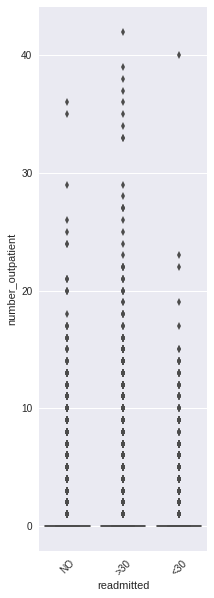

In [0]:
#Pintamos la columnas que tienen el P(75)=0 para ver los outliers
plt.figure(figsize = (3, 10))
ax = sns.boxplot(x='readmitted', y='number_outpatient', data=pacientes)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

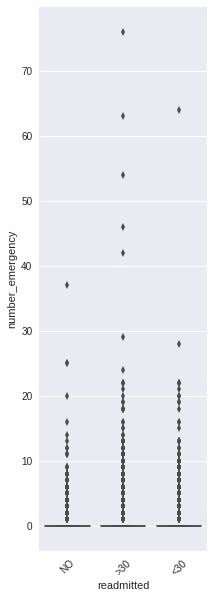

In [0]:
plt.figure(figsize = (3, 10))
ax = sns.boxplot(x='readmitted', y='number_emergency', data=pacientes)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

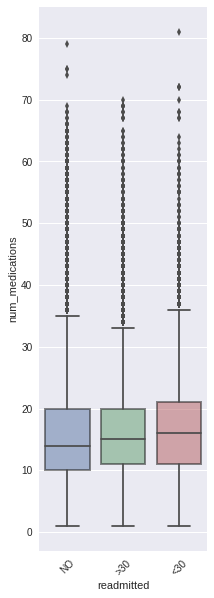

In [0]:
#Pintamos otra de las columnas para ver la diferencia con una columna con los datos más distribuidos
plt.figure(figsize = (3, 10))
ax = sns.boxplot(x='readmitted', y='num_medications', data=pacientes)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [0]:
#Creamos un DataFrame que sólo tenga valores categóricos
df_cat = pacientes.select_dtypes(include = ['object'])
df_cat

,encounter_id,patient_nbr,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,...,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesmed,readmitted,admission_source,admission_type,discharge_disposition
0,2278392,8222157,Caucasian,Female,[0-10),?,?,Pediatrics-Endocrinology,250.83,?,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,1968528,720936,Caucasian,Female,[70-80),?,?,Surgery-Cardiovascular/Thoracic,440,413,...,No,No,No,Down,Ch,Yes,>30,Physician Referral,None,Not Mapped
2,2223336,558360,AfricanAmerican,Female,[60-70),?,?,Orthopedics-Reconstructive,997,8,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
3,2298006,2519748,Caucasian,Male,[60-70),?,?,InternalMedicine,486,250,...,No,No,Steady,Down,Ch,Yes,NO,Physician Referral,None,Not Mapped
4,2356308,608841,AfricanAmerican,Female,[50-60),?,?,Family/GeneralPractice,250.03,401,...,No,No,No,Steady,No,Yes,>30,Physician Referral,None,Not Mapped
5,2363592,1059561,Caucasian,Female,[50-60),?,?,Cardiology,414,340,...,Steady,No,No,No,No,Yes,NO,Physician Referral,None,Not Mapped
6,2398146,8147493,Caucasian,Male,[60-70),?,?,Cardiology,414,496,...,No,No,No,No,No,Yes,NO,Physician Referral,None,Not Mapped
7,2422806,3377124,Caucasian,Male,[40-50),?,?,InternalMedicine,730,998,...,Steady,No,No,No,Ch,Yes,>30,Physician Referral,None,Not Mapped
8,2466036,4311585,Caucasian,Male,[60-70),?,?,Cardiology,414,276,...,No,No,No,Steady,Ch,Yes,>30,Physician Referral,None,Not Mapped
9,2473188,981198,Caucasian,Female,[60-70),?,?,Nephrology,250.4,403,...,No,No,No,Steady,No,Yes,>30,Physician Referral,None,Not Mapped




### Crear variables dummy en caso que sea conveniente

In [0]:
#Creamos una variable dummy. La creamos sobre readmitted, porque es la variable que queremos predecir
d_readmitted = pd.get_dummies(pacientes['readmitted'])
d_readmitted

,<30,>30,NO
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,0,1,0
8,0,1,0
9,0,1,0


In [0]:
#Añadimos las columnas dummies a nuestra tabla de datos
pacientes = pd.concat([pacientes, d_readmitted], axis=1, join='inner')
pacientes.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,insulin,change,diabetesmed,readmitted,admission_source,admission_type,discharge_disposition,<30,>30,NO
48456,68378838,78726978,Caucasian,Female,[70-80),?,3,?,?,40,...,No,No,Yes,NO,Physician Referral,Elective,Discharged to home,0,0,1
89248,193385796,84928698,Caucasian,Male,[80-90),?,6,MC,?,70,...,No,No,No,NO,Emergency Room,Emergency,Discharged/transferred to another short term hospital,0,0,1
42430,341431484,38942433,Caucasian,Male,[70-80),?,1,MC,?,10,...,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home,0,0,1
7592,141992940,90032184,AfricanAmerican,Female,[20-30),?,2,?,Family/GeneralPractice,33,...,Steady,No,Yes,>30,Physician Referral,Urgent,Discharged to home,0,1,0
35579,216645336,42031656,Caucasian,Female,[20-30),?,1,BC,?,36,...,Up,Ch,Yes,<30,Emergency Room,Emergency,Discharged to home,1,0,0




### Estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

In [0]:
#Como las columnas change y diabetesmed solo tienen 2 valores posibles, transformamos los valores a 0 y 1, ya que será más fácil de interpretar para los modelos
pacientes["change_binary"]= pacientes["change"].replace("No",0).replace("Ch",1)
pacientes["diabetesmed_binary"]= pacientes["diabetesmed"].replace("No",0).replace("Yes",1)

In [0]:
#Borramos las columnas change y diabetesmed, ya que los valores son redundantes con los de las nuevas columnas
del pacientes["change"]
del pacientes["diabetesmed"]

In [0]:
#Reemplazamos los valores ? por Nulo
pacientes[['weight','payer_code','race','medical_specialty']]=pacientes[['weight','payer_code','race','medical_specialty']].replace(regex = '[?]',value = np.nan)
pacientes['gender'] = pacientes['gender'].replace('Unknown/Invalid',np.nan)

#Miramos que ahora tenemos registros nulos en alguna de nuestras columnas
pacientes.isnull().sum()/pacientes.shape[0]

encounter_id             0.000000
patient_nbr              0.000000
race                     0.022336
gender                   0.000029
age                      0.000000
weight                   0.968585
time_in_hospital         0.000000
payer_code               0.395574
medical_specialty        0.490822
num_lab_procedures       0.000000
num_procedures           0.000000
num_medications          0.000000
number_outpatient        0.000000
number_emergency         0.000000
number_inpatient         0.000000
diag_1                   0.000000
diag_2                   0.000000
diag_3                   0.000000
number_diagnoses         0.000000
max_glu_serum            0.000000
a1cresult                0.000000
metformin                0.000000
glimepiride              0.000000
glipizide                0.000000
glyburide                0.000000
pioglitazone             0.000000
rosiglitazone            0.000000
insulin                  0.000000
readmitted               0.000000
admission_sour



### Antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear

In [0]:
#Manteniendo sólo la columna NO de nuestra variable dummy podemos convertir nuestra variable "readmitted" en una variable de dos valores (0=ha sido readmitido, 1=no ha sido readmitido)
#Teniendo la variable en formato numérico podremos calcular la matriz de correlación y ver de una manera más sencilla qué valores están más correlacionados con la variable a predecir
del pacientes[">30"]
del pacientes["<30"]

In [0]:
#Renombramos la variable NO a no_readmitted
pacientes = pacientes.rename(columns={'NO':'non_readmitted'})

In [0]:
#Como hemos visto que el número de visitas al hospital es un dato relevante, vamos a agrupar los valores en 4 categorías para luego poder analizarlas
pacientes["number_inpatient_group"] = pacientes["number_inpatient"].replace({0: "Grupo 1 [0-1]", 1:"Grupo 1 [0-1]", 2: "Grupo 2 [2-5]",3: "Grupo 2 [2-5]",4: "Grupo 2 [2-5]",5: "Grupo 2 [2-5]",
                                                                             6:"Grupo 3 [6-10]",7:"Grupo 3 [6-10]",8:"Grupo 3 [6-10]",9:"Grupo 3 [6-10]",
                                                                             10:"Grupo 3 [6-10]",11:"Grupo 4 [11-21]",12:"Grupo 4 [11-21]",13:"Grupo 4 [11-21]",14:"Grupo 4 [11-21]",
                                                                             15:"Grupo 4 [11-21]",16:"Grupo 4 [11-21]",17:"Grupo 4 [11-21]",18:"Grupo 4 [11-21]",19:"Grupo 4 [11-21]",
                                                                             21:"Grupo 4 [11-21]"})



# Exploratory Data Analysis



### Crear la matriz de correlación

In [0]:
#Para crear la matriz de correlación seleccionamos aquellas variables que son numéricas
df_numerical_and_bin = pacientes.select_dtypes(include = ['int64','uint8'])
df_numerical_and_bin.head(5)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,non_readmitted,change_binary,diabetesmed_binary
0,1,41,0,1,0,0,0,1,1,0,0
1,10,56,2,24,0,0,0,9,0,1,1
2,9,60,5,17,0,0,0,8,1,0,0
3,4,47,0,15,0,0,0,8,1,1,1
4,1,50,0,8,0,0,0,8,0,0,1


In [0]:
#Creamos la matriz de correlación
corr_m = df_numerical_and_bin.corr()
corr_m

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,non_readmitted,change_binary,diabetesmed_binary
time_in_hospital,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186,-0.051289,0.109173,0.062520
num_lab_procedures,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773,-0.039253,0.063958,0.033107
num_procedures,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734,0.044748,0.004448,-0.006821
num_medications,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526,-0.046772,0.246846,0.186910
number_outpatient,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152,-0.082142,0.024794,0.016456
number_emergency,-0.009681,-0.002279,-0.038179,0.013180,0.091459,1.000000,0.266559,0.055539,-0.103011,0.038818,0.025923
number_inpatient,0.073623,0.039231,-0.066236,0.064194,0.107338,0.266559,1.000000,0.104710,-0.217194,0.024042,0.026001
number_diagnoses,0.220186,0.152773,0.073734,0.261526,0.094152,0.055539,0.104710,1.000000,-0.112564,0.053106,0.021186
non_readmitted,-0.051289,-0.039253,0.044748,-0.046772,-0.082142,-0.103011,-0.217194,-0.112564,1.000000,-0.046008,-0.061508
change_binary,0.109173,0.063958,0.004448,0.246846,0.024794,0.038818,0.024042,0.053106,-0.046008,1.000000,0.506370


In [0]:
sol =(corr_m.where(np.triu(np.ones(corr_m.shape),k=1).astype(np.bool)).stack().sort_values(ascending=True))

sol[sol > 0.5]

change_binary  diabetesmed_binary    0.50637
dtype: float64



### Pintar la matriz de correlación

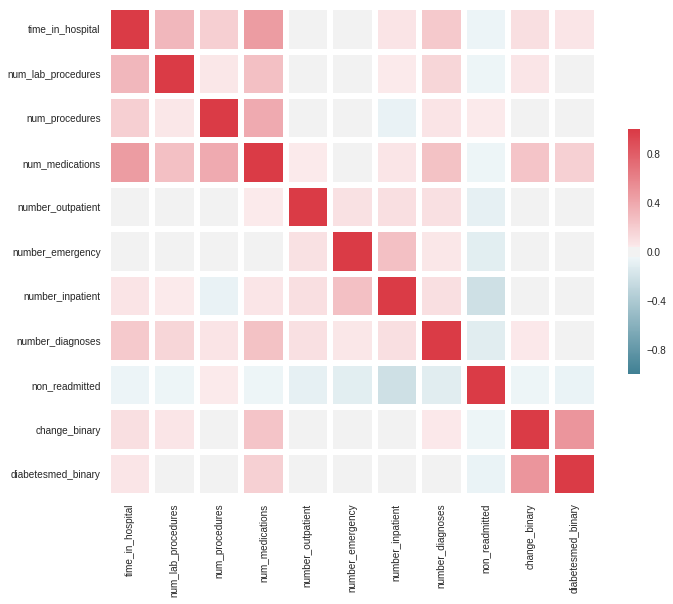

In [0]:
#Pintamos la matriz de correlación
f, ax = plt.subplots(figsize =(11,9))
cmap = sns.diverging_palette(220,10, as_cmap=True)
sns.heatmap(df_numerical_and_bin.corr(), cmap = cmap, vmax = 1, center = 0, square = True, linewidths =5, cbar_kws={'shrink':.5})



### Otros escenarios para medir la correlación

En anteriores pasos hemos detectado que hay 2 columnas que tienen gran parte de sus valores a 0 (**number_emergency** y **number_outpatient**).

Vamos a analizar la correlación de todas las variables numéricas separando el conjunto inicial en dos poblaciones:

- Registros con estas dos columnas a 0
- Registros con estas dos columnas distintas a 0


In [0]:
#Filtramos nuestro DataFrame para coger los registros cuyos datos en esas dos columnas son igual a cero
df_numerical_and_bin2 = df_numerical_and_bin[(df_numerical_and_bin["number_outpatient"]==0) & (df_numerical_and_bin["number_emergency"]==0)]

In [0]:
#Creamos la matriz de correlación
corr_m = df_numerical_and_bin2.corr()
corr_m

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,non_readmitted,change_binary,diabetesmed_binary
time_in_hospital,1.000000,0.323113,0.184788,0.460223,NaN,NaN,0.083144,0.225171,-0.058019,0.111319,0.064651
num_lab_procedures,0.323113,1.000000,0.051208,0.266620,NaN,NaN,0.040495,0.141153,-0.032034,0.076881,0.046725
num_procedures,0.184788,0.051208,1.000000,0.398851,NaN,NaN,-0.068254,0.085290,0.039843,0.009404,-0.004253
num_medications,0.460223,0.266620,0.398851,1.000000,NaN,NaN,0.041600,0.264982,-0.035673,0.250535,0.188833
number_outpatient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_emergency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_inpatient,0.083144,0.040495,-0.068254,0.041600,NaN,NaN,1.000000,0.091090,-0.190579,0.008273,0.027587
number_diagnoses,0.225171,0.141153,0.085290,0.264982,NaN,NaN,0.091090,1.000000,-0.102577,0.058746,0.020924
non_readmitted,-0.058019,-0.032034,0.039843,-0.035673,NaN,NaN,-0.190579,-0.102577,1.000000,-0.042700,-0.063680
change_binary,0.111319,0.076881,0.009404,0.250535,NaN,NaN,0.008273,0.058746,-0.042700,1.000000,0.503183


In [0]:
#Calculamos qué par de variables están correlacionadas > 0.5
sol =(corr_m.where(np.triu(np.ones(corr_m.shape),k=1).astype(np.bool)).stack().sort_values(ascending=True))

sol[sol > 0.5]

change_binary  diabetesmed_binary    0.503183
dtype: float64

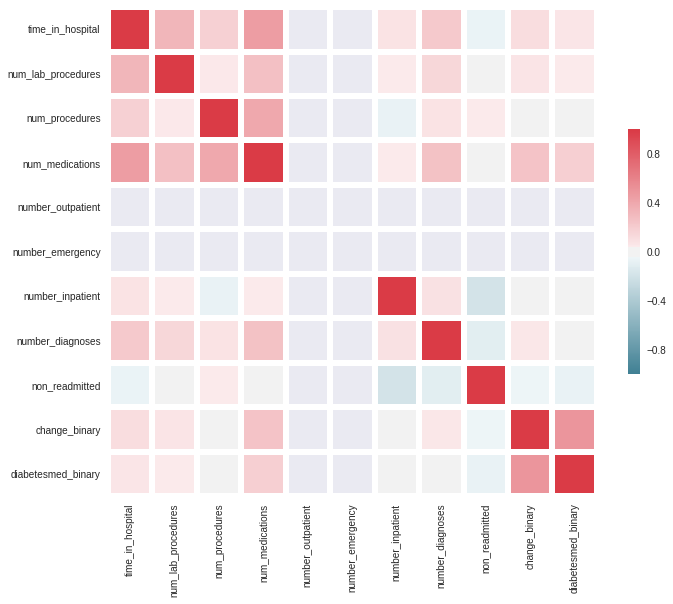

In [0]:
#Pintamos la matriz de correlación
f, ax = plt.subplots(figsize =(11,9))
cmap = sns.diverging_palette(220,10, as_cmap=True)
sns.heatmap(df_numerical_and_bin2.corr(), cmap = cmap, vmax = 1, center = 0, square = True, linewidths =5, cbar_kws={'shrink':.5})

In [0]:
#Filtramos nuestro DataFrame para coger los registros cuyos datos en esas dos columnas son distintos a cero
df_numerical_and_bin3 = df_numerical_and_bin[(df_numerical_and_bin["number_outpatient"]!=0) & (df_numerical_and_bin["number_emergency"]!=0)]

In [0]:
#Creamos la matriz de correlación
corr_m= df_numerical_and_bin3.corr()
corr_m

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,non_readmitted,change_binary,diabetesmed_binary
time_in_hospital,1.000000,0.283837,0.266957,0.514771,0.032051,-0.038146,0.056804,0.207474,-0.042541,0.083621,0.037443
num_lab_procedures,0.283837,1.000000,0.116489,0.274914,0.059966,-0.005688,0.045408,0.218576,-0.061887,-0.029644,-0.064655
num_procedures,0.266957,0.116489,1.000000,0.360709,0.005256,-0.028274,-0.012004,0.093982,0.011514,-0.009353,-0.012208
num_medications,0.514771,0.274914,0.360709,1.000000,0.043810,-0.023981,0.083715,0.252834,-0.058315,0.195879,0.143513
number_outpatient,0.032051,0.059966,0.005256,0.043810,1.000000,-0.002066,0.000302,0.076948,-0.012589,-0.017568,-0.020478
number_emergency,-0.038146,-0.005688,-0.028274,-0.023981,-0.002066,1.000000,0.198436,0.010361,-0.101118,0.013068,0.002046
number_inpatient,0.056804,0.045408,-0.012004,0.083715,0.000302,0.198436,1.000000,-0.012196,-0.211831,0.011147,-0.006132
number_diagnoses,0.207474,0.218576,0.093982,0.252834,0.076948,0.010361,-0.012196,1.000000,-0.042697,-0.032772,-0.029906
non_readmitted,-0.042541,-0.061887,0.011514,-0.058315,-0.012589,-0.101118,-0.211831,-0.042697,1.000000,-0.006543,-0.027942
change_binary,0.083621,-0.029644,-0.009353,0.195879,-0.017568,0.013068,0.011147,-0.032772,-0.006543,1.000000,0.527419


In [0]:
#Calculamos qué par de variables están correlacionadas > 0.5
sol =(corr_m.where(np.triu(np.ones(corr_m.shape),k=1).astype(np.bool)).stack().sort_values(ascending=True))

sol[sol > 0.5]

time_in_hospital  num_medications       0.514771
change_binary     diabetesmed_binary    0.527419
dtype: float64

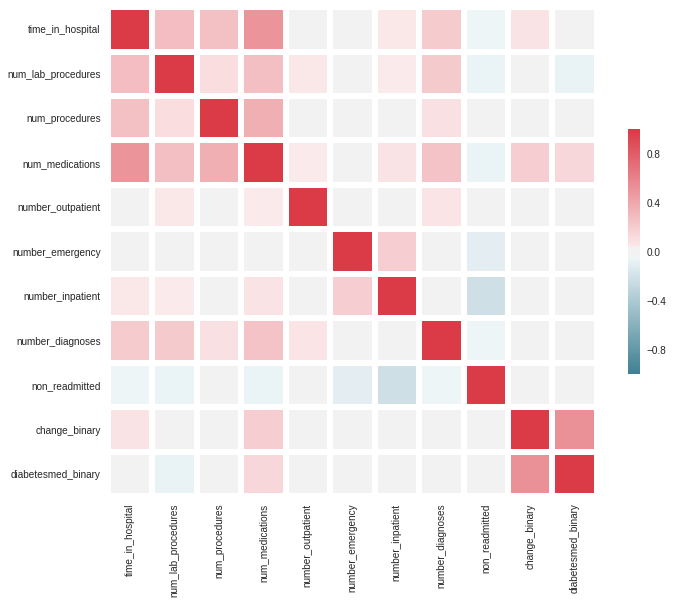

In [0]:
#Pintamos la matriz de correlación
f, ax = plt.subplots(figsize =(11,9))
cmap = sns.diverging_palette(220,10, as_cmap=True)
sns.heatmap(df_numerical_and_bin3.corr(), cmap = cmap, vmax = 1, center = 0, square = True, linewidths =5, cbar_kws={'shrink':.5})



### Determinar qué par de variables están correlacionadas

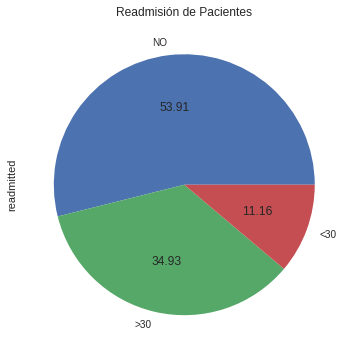

In [0]:
#En primer lugar revisamos el porcentaje de pacientes que han sido readmitidos y cuáles no
plot = pacientes['readmitted'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Readmisión de Pacientes')

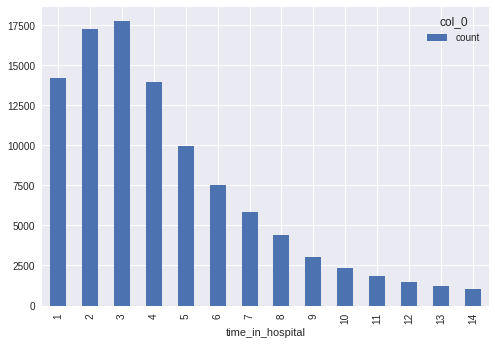

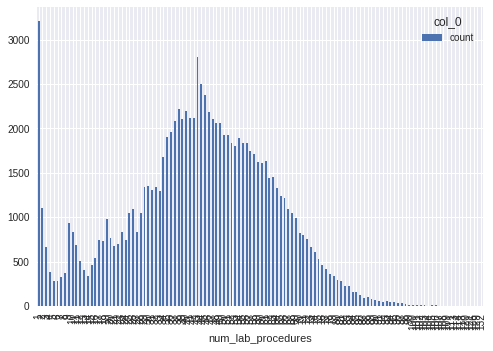

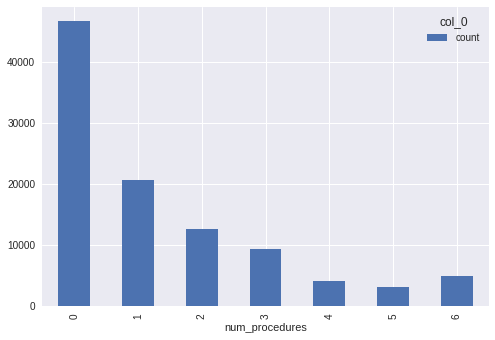

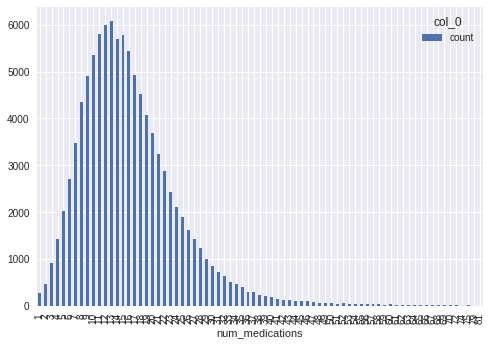

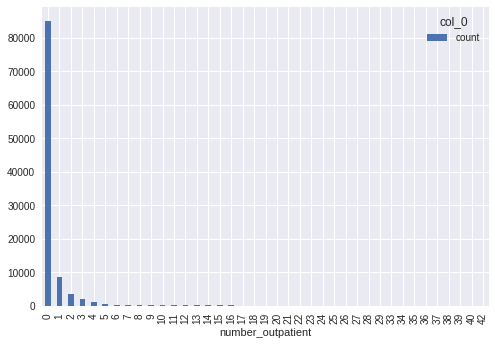

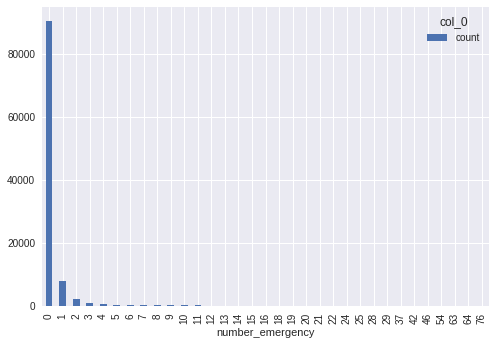

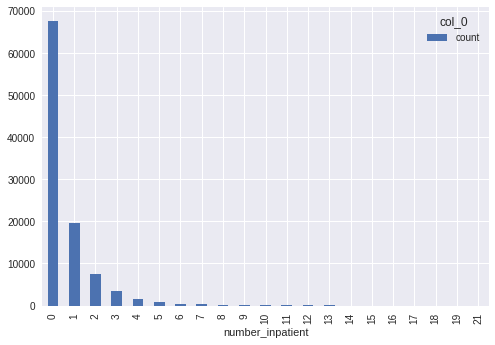

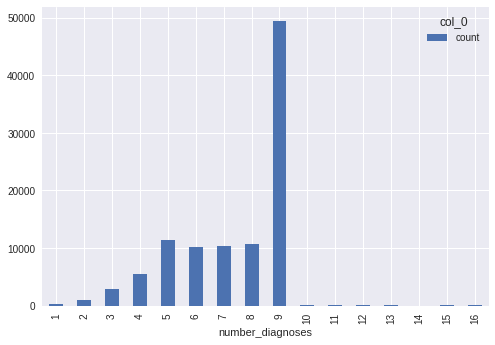

In [0]:
#Revisamos la distribución de todas las variables numéricas
for x in df_numerical.columns:
  my_table = pd.crosstab(index = df_numerical[x],
                             columns="count")

  my_table.plot.bar()



Text(10, 110, '(Azul = Readmitido, Verde = No Readmitido)')

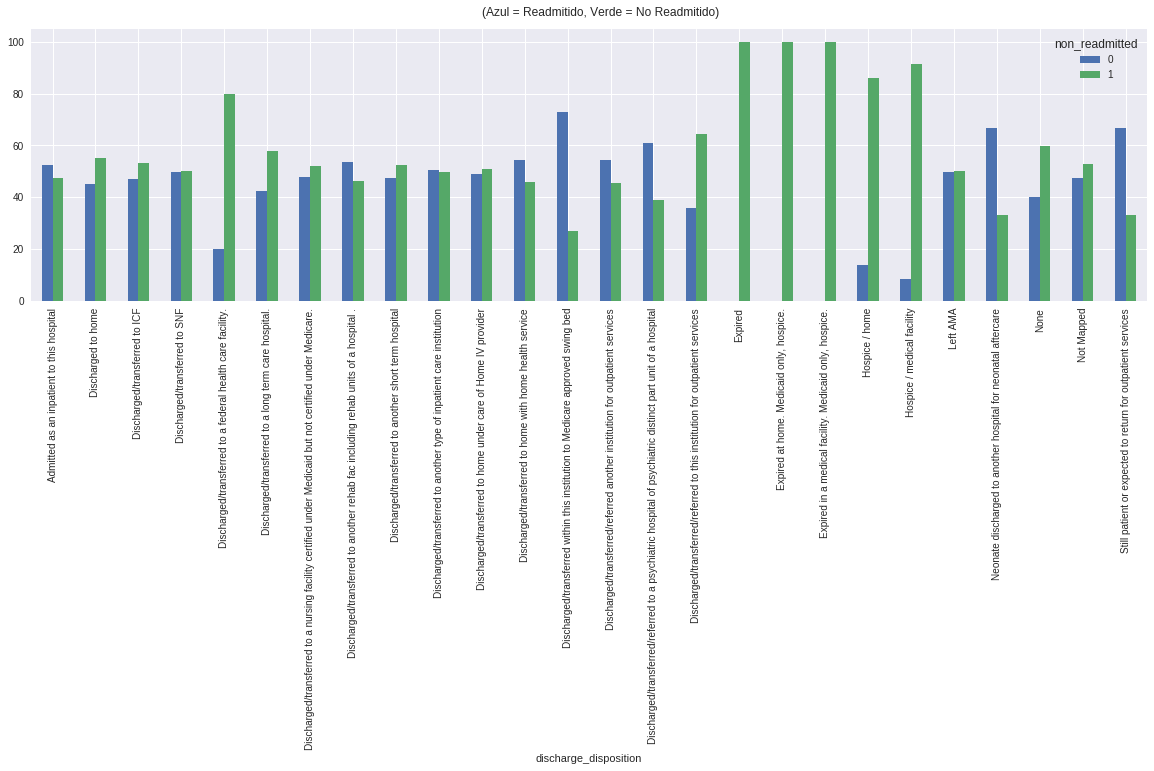

In [0]:
#Como queremos ver si una persona es readmitida y nos da igual cuándo es readmitida, utilizamos la variable binaria que hemos creado (non_readmitted)
#En primer lugar revisamos la influencia de la variable discharge_disposition en la readmisión de un paciente
plot = pd.crosstab(index=pacientes['discharge_disposition'],
            columns=pacientes['non_readmitted'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(10,110,"(Azul = Readmitido, Verde = No Readmitido)")
#Dependiendo del destino del paciente cuando sale del hospital, también se puede ver que en algunos casos el % de readmisiones es alto

Text(6, 110, '(Azul = Readmitido, Verde = No Readmitido)')

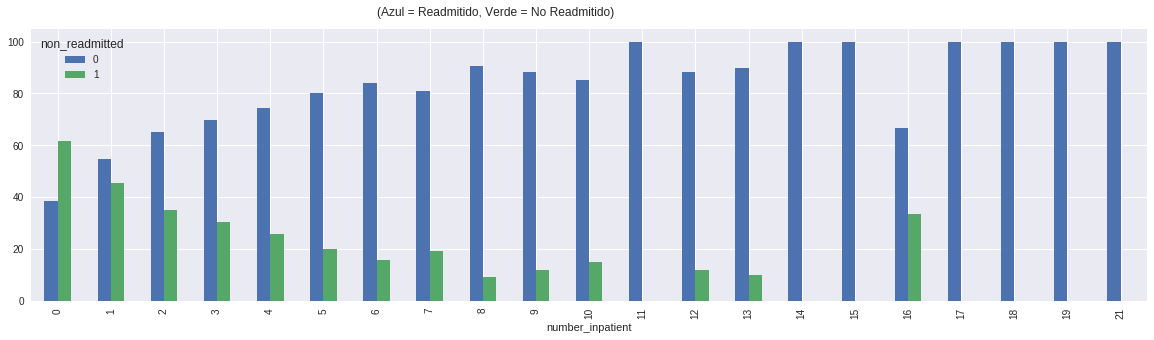

In [0]:
#En segundo lugar analizamos la influencia que tiene en la readmisión el número de veces que el paciente ha ido al hospital (0=readmitido, 1=no readmitido)
plot = pd.crosstab(index=pacientes['number_inpatient'],
            columns=pacientes['non_readmitted'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(6,110,"(Azul = Readmitido, Verde = No Readmitido)")
#Cuantas más visitas haya hecho al hospital, más probable es que vuelva a ser readmitido

Text(2, 110, '(Azul = Readmitido, Verde = No Readmitido)')

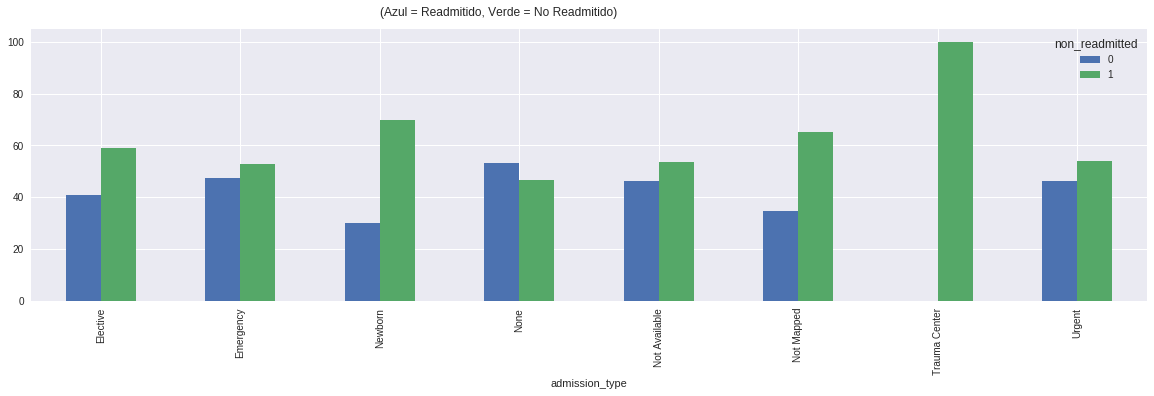

In [0]:
#Dependiendo de la procedencia del paciente, también se puede ver si hay más o menos posibilidades de que vuelva a ser readmitido en el hospital
plot = pd.crosstab(index=pacientes['admission_type'],
            columns=pacientes['non_readmitted'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(2,110,"(Azul = Readmitido, Verde = No Readmitido)")

Text(1, 100, '(Azul = Readmitido, Verde = No Readmitido)')

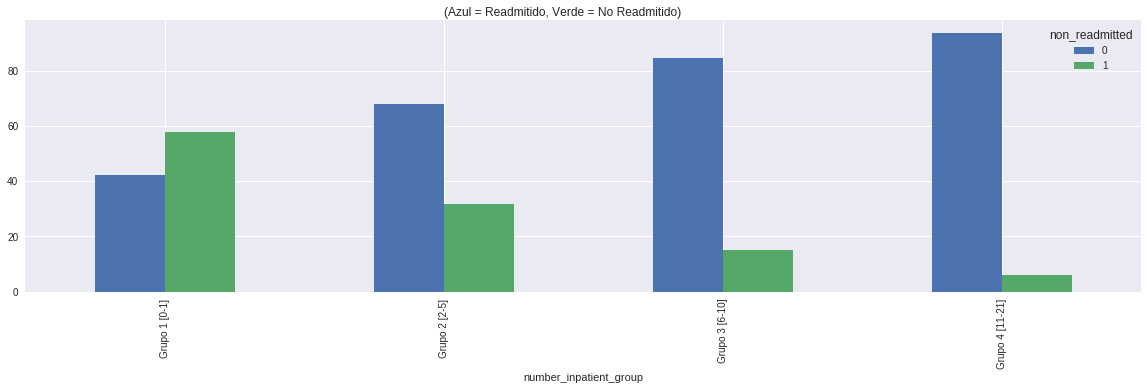

In [0]:
#Dependiendo del número de veces que ha ido el paciente al hospital vemos las probabilidades de volver a ser readmitido
plot = pd.crosstab(index=pacientes['number_inpatient_group'],
            columns=pacientes['non_readmitted'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(1,100,"(Azul = Readmitido, Verde = No Readmitido)")